# Calculation module

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
sys.path.insert(0, '../')

from clouddrift import dataformat

## Create a ragged array for the demonstration

In [2]:
from data import gdp

In [3]:
drifter_ids = gdp.download(n_random_id=100)

100%|█████████████████████████████████████████| 100/100 [00:00<00:00, 236432.02it/s]


In [4]:
coords = {'ids': 'ids', 'time': 'time', 'lon': 'longitude', 'lat': 'latitude'}
metadata = ['ID', 'rowsize', 'WMO', 'expno', 'deploy_date', 'deploy_lat', 'deploy_lon', 'end_date', 'end_lat', 'end_lon', 'drogue_lost_date', 'typedeath', 'typebuoy', 'location_type', 'DeployingShip', 'DeploymentStatus', 'BuoyTypeManufacturer', 'BuoyTypeSensorArray', 'CurrentProgram', 'PurchaserFunding', 'SensorUpgrade', 'Transmissions', 'DeployingCountry', 'DeploymentComments', 'ManufactureYear', 'ManufactureMonth', 'ManufactureSensorType', 'ManufactureVoltage', 'FloatDiameter', 'SubsfcFloatPresence', 'DrogueType', 'DrogueLength', 'DrogueBallast', 'DragAreaAboveDrogue', 'DragAreaOfDrogue', 'DragAreaRatio', 'DrogueCenterDepth', 'DrogueDetectSensor']
data = ['ve', 'vn', 'err_lat', 'err_lon', 'err_ve', 'err_vn', 'gap', 'sst', 'sst1', 'sst2', 'err_sst', 'err_sst1', 'err_sst2', 'flg_sst', 'flg_sst1', 'flg_sst2', 'drogue_status']

ra = dataformat.create_ragged_array(drifter_ids,
                         coords, 
                         metadata, 
                         data,
                         preprocess_func=gdp.preprocess,  # function of the dataset
                         rowsize_func=gdp.rowsize
                        )

ds = ra.to_awkward()  # return an Awkward Array

Calculating the number of observations: 100%|█████| 100/100 [00:01<00:00, 65.33it/s]
/Users/pmiron/miniforge3/envs/clouddrift/lib/python3.9/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
Filling the ragged array: 100%|███████████████████| 100/100 [00:02<00:00, 33.58it/s]


# Load Periodogram calculation per trajectory

In [5]:
from clouddrift import spectrum

In [6]:
%%time
ret = spectrum.periodogram_per_traj(ds.obs.ve + 1j*ds.obs.vn)

CPU times: user 84.4 ms, sys: 14.4 ms, total: 98.8 ms
Wall time: 103 ms


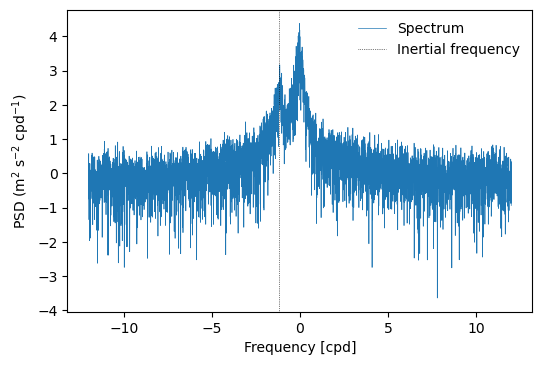

In [7]:
# selected trajectory [0,100]
i = 42

# calculate inertial frequency in cycle per day [cpd] from the mean latitude of trajectory
omega = 7.2921159e-5  # Earth's rotation rate [rad/s]
seconds_per_day = 60*60*24  # [s]
fi = -2*omega*(seconds_per_day/(2*np.pi))*np.sin(np.mean(np.radians(ds.obs.lat[i])))

# define frequency scale/abscissa
dt = 1/24  # [-]
f = np.fft.fftfreq(ds.rowsize[i], dt) 
ss = np.log10(ret[i])  # spectrum of the ith trajectory 

fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)

h1, = ax.plot(np.fft.fftshift(f), np.fft.fftshift(ss), scaley=True, label='Spectrum', linewidth=0.5)
h2 = ax.axvline(x=fi,color='k',linestyle=':', label='Inertial frequency', linewidth=0.5)
ax.legend(frameon=False)
ax.set_ylabel('PSD (m$^2$ s$^{-2}$ cpd$^{-1}$)')
ax.set_xlabel('Frequency [cpd]');